In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import BernoulliNB, CategoricalNB, ComplementNB, GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, RandomTreesEmbedding, BaggingClassifier, StackingClassifier, VotingClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier

# Импорт библиотек

In [6]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
df.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
802,803,1,1,"Carter, Master. William Thornton II",male,11.0,1,2,113760,120.00,B96 B98,S
465,466,0,3,"Goncalves, Mr. Manuel Estanslas",male,38.0,0,0,SOTON/O.Q. 3101306,7.05,NaN,S
461,462,0,3,"Morley, Mr. William",male,34.0,0,0,364506,8.05,NaN,S


## Выставление настроек

In [7]:
2+2

4

# Обработка данных

Начнем с того, что приведем все названия колонок к "змеиной нотации"

In [8]:
df.columns = df.columns.str.lower()
test.columns = test.columns.str.lower()

Переведем колонку с индексом в индекс датафрейма

In [9]:
df = df.set_index('passengerid')
test = test.set_index('passengerid')

Выведем общую информацию об обучающем и тестовом датасетах

In [10]:
def full_info(df):
    display(pd.DataFrame({'Non-Null Count': (~df.isna()).sum(),
                          'Null Count': df.isna().sum(),
                          'Dtype': df.dtypes}).join(df.describe().T).rename_axis('Feature', axis=1).fillna(''))

In [11]:
full_info(df)

Feature,Non-Null Count,Null Count,Dtype,count,mean,std,min,25%,50%,75%,max
survived,891,0,int64,891.0,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
pclass,891,0,int64,891.0,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
name,891,0,object,,,,,,,,
sex,891,0,object,,,,,,,,
age,714,177,float64,714.0,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0
sibsp,891,0,int64,891.0,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
parch,891,0,int64,891.0,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
ticket,891,0,object,,,,,,,,
fare,891,0,float64,891.0,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292
cabin,204,687,object,,,,,,,,


In [12]:
full_info(test)

Feature,Non-Null Count,Null Count,Dtype,count,mean,std,min,25%,50%,75%,max
pclass,418,0,int64,418.0,2.26555,0.841838,1.0,1.0,3.0,3.0,3.0
name,418,0,object,,,,,,,,
sex,418,0,object,,,,,,,,
age,332,86,float64,332.0,30.27259,14.181209,0.17,21.0,27.0,39.0,76.0
sibsp,418,0,int64,418.0,0.447368,0.89676,0.0,0.0,0.0,1.0,8.0
parch,418,0,int64,418.0,0.392344,0.981429,0.0,0.0,0.0,0.0,9.0
ticket,418,0,object,,,,,,,,
fare,417,1,float64,417.0,35.627188,55.907576,0.0,7.8958,14.4542,31.5,512.3292
cabin,91,327,object,,,,,,,,
embarked,418,0,object,,,,,,,,


Выводы следующие:
* В обучающем датасете 891 наблюдение
* Пропуски есть в колонках с возрастом и номером кабины(?). Пропуски есть также и в тестовом датасете, поэтому модель должна уметь работать с ними
* Не все типы данных оптимальны
* есть небольшой дисбаланс в пользу погибших

Удалим признак с номером кабины, так как восстановить эту информацию и использовать далее не удастся

In [13]:
try:
    df = df.drop('cabin', axis=1)
    test = test.drop('cabin', axis=1)
except:
    print('Признака уже нет')

Поменяем типы данных

In [14]:
df['pclass'] = df['pclass'].replace({1: 'first', 2: 'second', 3: 'third'})
test['pclass'] = test['pclass'].replace({1: 'first', 2: 'second', 3: 'third'})

In [15]:
df['sex'] = df['sex'].replace({'male': 0, 'female': 1}).astype('bool')
test['sex'] = test['sex'].replace({'male': 0, 'female': 1}).astype('bool')

Добавим новый признак, равный длине имени. Позже проверим, как это влияет на шансы выжить

In [16]:
df['name_length'] = df['name'].apply(len)
test['name_length'] = test['name'].apply(len)

Посмотрим на признак "номер билета"

In [17]:
df['ticket'].value_counts()

ticket
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: count, Length: 681, dtype: int64

Совпадающих значений мало, удалим признак

In [18]:
df = df.drop('ticket', axis=1)
test = test.drop('ticket', axis=1)

# Исследование данных

Построим по порядку для всех признаков графики, позволяющие пока визуально оценить влияние признака на целевую переменную

## Номер класса

In [19]:
df.groupby('pclass')['survived'].value_counts(normalize=True).round(2)

pclass  survived
first   1           0.63
        0           0.37
second  0           0.53
        1           0.47
third   0           0.76
        1           0.24
Name: proportion, dtype: float64

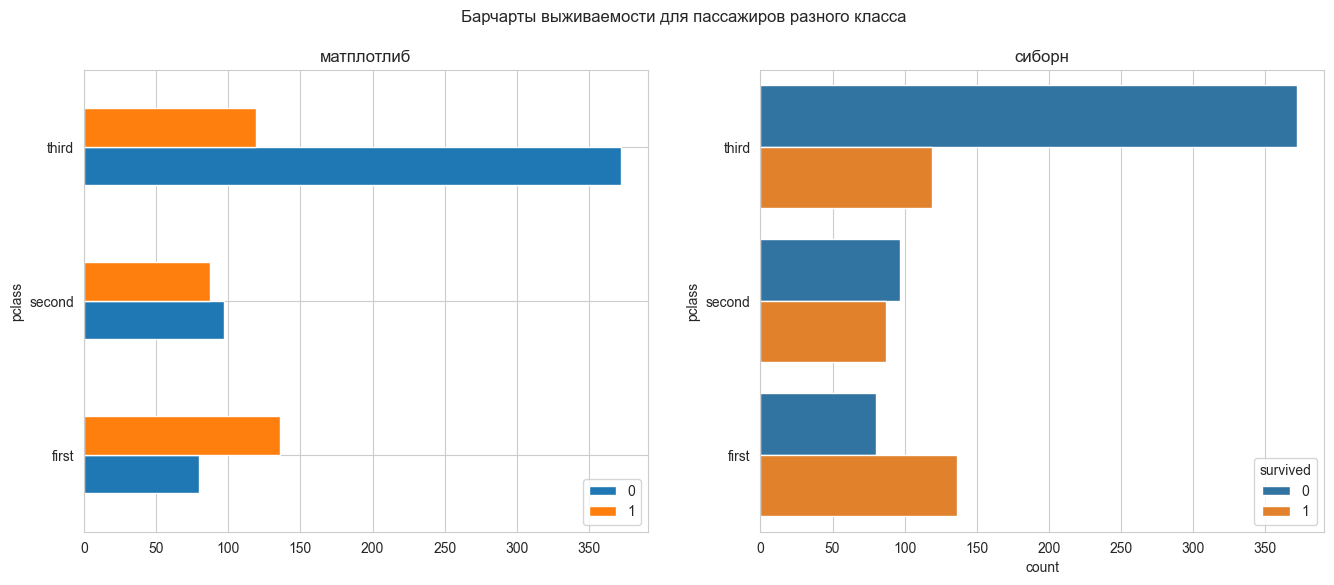

In [20]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 6))

plt.suptitle('Барчарты выживаемости для пассажиров разного класса')
df.groupby(['pclass', 'survived'])['survived'].value_counts().unstack().plot.barh(ax=ax1);
ax1.legend(loc='lower right');
ax1.set_title('матплотлиб')

sns.barplot(data=df.groupby(['pclass', 'survived'])['survived'].value_counts().reset_index(),
            y='pclass',
            order=['third', 'second', 'first'],
            x='count',
            hue='survived',
            # hue_order=[0, 1],
            orient='h',
            ax=ax2);
ax2.set_title('сиборн');

Предсказуемо, шансы выжить у пассажиров первого класса были выше

## Имя

Проверим, существует ли связь между длиной имени и вероятностью выжить.

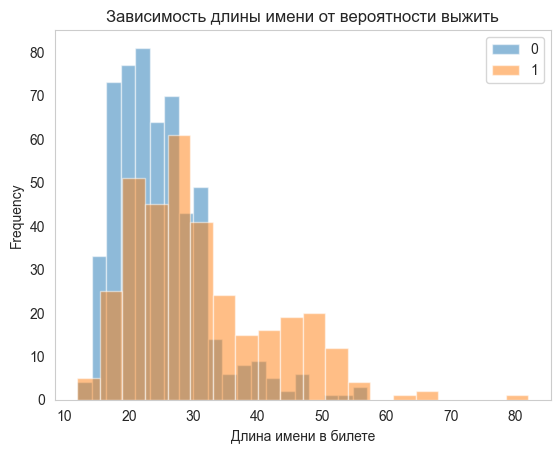

In [21]:
df.groupby('survived')['name_length'].plot(bins=20, alpha=0.5, kind='hist', grid=False);
plt.legend();
plt.title('Зависимость длины имени от вероятности выжить')
plt.xlabel('Длина имени в билете');

Удалим признак с именем

In [22]:
df = df.drop('name', axis=1)

## Пол

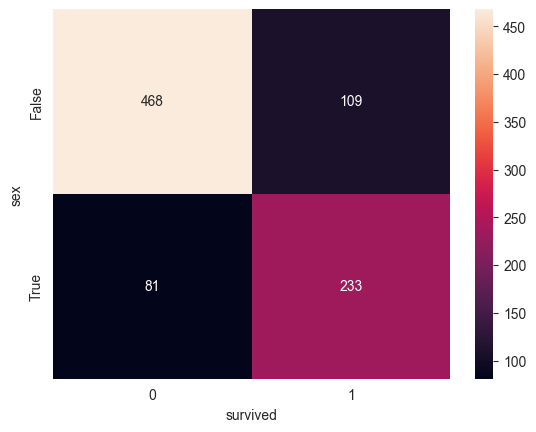

In [23]:
sns.heatmap(df.groupby(['sex', 'survived'])['survived'].count().unstack(), annot=True, fmt='.3g');

Среди женщин выжило примерно 75%, среди мужчин - 20%

## Возраст

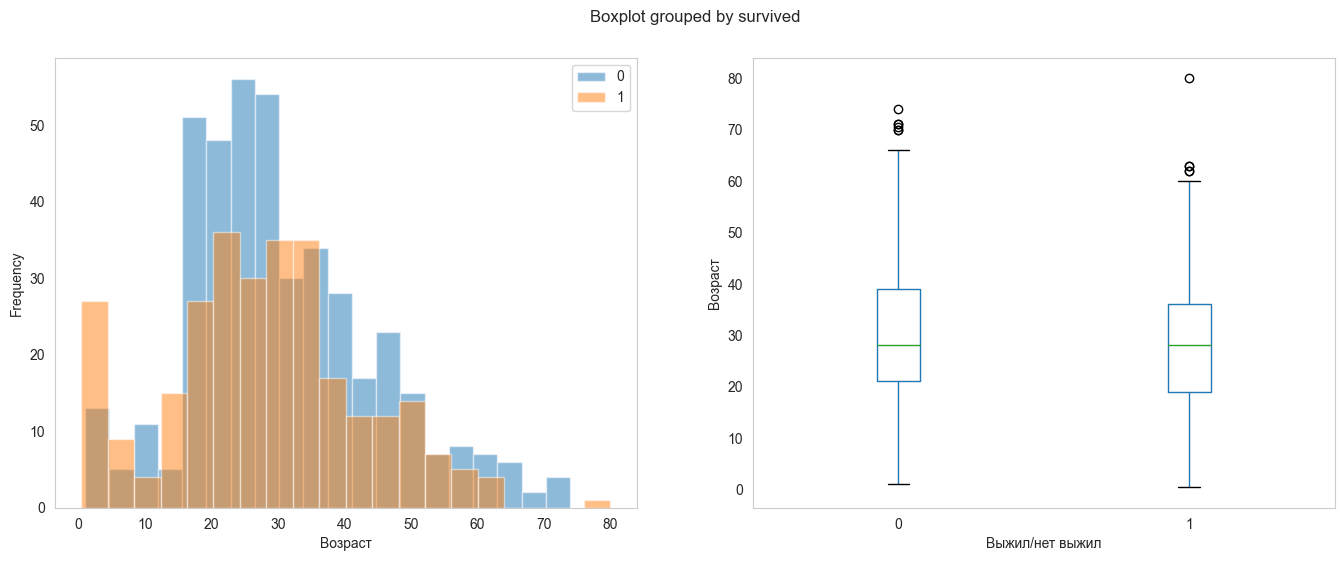

In [24]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 6))

# fig.title('a')
fig.suptitle('b')
plt.title('c')
plt.suptitle('d')

df.groupby('survived')['age'].plot(bins=20, alpha=0.5, kind='hist', grid=False, ax=ax1);
ax1.legend();
ax1.set_xlabel('Возраст');

df.boxplot(column='age', by='survived', grid=False, ax=ax2);
ax2.set_xlabel('');
ax2.set_title('')
ax2.set_xlabel('Выжил/нет выжил')
ax2.set_ylabel('Возраст');

# Обучение моделей

## Разделение датасета на признаки и таргет, на обучающую и тестовую выборки

In [25]:
x = df.drop('survived', axis=1)
y = df['survived']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

## Линейные модели

Построим пайплайн преобразования признаков для линейной модели

In [26]:
num_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                         ('scaler', StandardScaler())])

cat_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                         ('ohe', OneHotEncoder(drop='first'))])

transformer = ColumnTransformer(transformers=[('nums', num_ct, selector(dtype_exclude="object")),
                                              ('cats', cat_ct, selector(dtype_include="object"))],
                                remainder='passthrough')
Pipeline(steps=[('', transformer)])

Pipeline(steps=[('',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('nums',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000212A307FA60>),
                                                 ('cats',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000212A307FA30>)]))])

Посмотрим на получившиеся признаки. У них теперь нет имен, но по порядку преобразвоаний можно увидеть, что последние 4 признака - это категориальные признаки, подвергнутые OHE.

In [27]:
full_info(pd.DataFrame(transformer.fit_transform(x_train)).astype('float'))

Feature,Non-Null Count,Null Count,Dtype,count,mean,std,min,25%,50%,75%,max
0,712,0,float64,712.0,2.993860e-17,1.000703,-0.737881,-0.737881,-0.737881,1.355232,1.355232
1,712,0,float64,712.0,-2.183023e-16,1.000703,-2.310194,-0.615224,0.000000,0.405842,3.940300
2,712,0,float64,712.0,5.738231e-17,1.000703,-0.460103,-0.460103,-0.460103,0.437413,6.720019
3,712,0,float64,712.0,-1.247442e-17,1.000703,-0.474312,-0.474312,-0.474312,-0.474312,6.045189
4,712,0,float64,712.0,-7.235161e-17,1.000703,-0.620689,-0.469374,-0.361976,-0.044414,9.197546
5,712,0,float64,712.0,-1.459507e-16,1.000703,-1.640237,-0.749089,-0.192122,0.364845,4.486401
6,712,0,float64,712.0,2.092697e-01,0.407073,0.000000,0.000000,0.000000,0.000000,1.000000
7,712,0,float64,712.0,5.575843e-01,0.497022,0.000000,0.000000,1.000000,1.000000,1.000000
8,712,0,float64,712.0,9.410112e-02,0.292175,0.000000,0.000000,0.000000,0.000000,1.000000
9,712,0,float64,712.0,7.261236e-01,0.446260,0.000000,0.000000,1.000000,1.000000,1.000000


Добавим в пайплайн классификатор

In [28]:
lr_pipe = Pipeline(steps=[('transformer', transformer), ('clf', LogisticRegression(random_state=123))])

params = [{'transformer__nums__imputer': [SimpleImputer()],
           'transformer__nums__imputer__strategy': ['mean', 'median'],
           'clf__penalty': ['none', 'l2'],
           'clf__C': [0.1, 1, 10, 100]
          },
          { 'transformer__nums__imputer': [IterativeImputer(random_state=123)],
           'clf__penalty': ['none', 'l2'],
           'clf__C': [0.1, 1, 10, 100]
          }]

lr_gs    = GridSearchCV(estimator=lr_pipe,
                        param_grid=params,
                        scoring='roc_auc',
                        refit=True,
                        cv=3,
                        n_jobs=-1,
                        verbose=10)
lr_gs.fit(x_train, y_train)
lr_best = lr_gs.best_estimator_;

Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [29]:
display(pd.DataFrame(lr_gs.cv_results_).sort_values('rank_test_score'))
print(f'параметры: {pd.DataFrame(lr_gs.cv_results_).sort_values("rank_test_score").head(1)["params"].values[0]}',
      f'\nroc-auc: {pd.DataFrame(lr_gs.cv_results_).sort_values("rank_test_score").head(1)["mean_test_score"].values[0]:.4f}')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__penalty,param_transformer__nums__imputer,param_transformer__nums__imputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
23,0.058998,0.002944,0.010998,0.002160,100,l2,IterativeImputer(random_state=123),NaN,"{'clf__C': 100, 'clf__penalty': 'l2', 'transfo...",0.868854,0.810270,0.886582,0.855235,0.032609,1
20,0.068333,0.001885,0.016000,0.002826,10,none,IterativeImputer(random_state=123),NaN,"{'clf__C': 10, 'clf__penalty': 'none', 'transf...",0.868854,0.810195,0.886582,0.855210,0.032643,2
18,0.086998,0.016392,0.014667,0.000942,1,none,IterativeImputer(random_state=123),NaN,"{'clf__C': 1, 'clf__penalty': 'none', 'transfo...",0.868854,0.810195,0.886582,0.855210,0.032643,2
16,0.069333,0.000472,0.013666,0.000470,0.1,none,IterativeImputer(random_state=123),NaN,"{'clf__C': 0.1, 'clf__penalty': 'none', 'trans...",0.868854,0.810195,0.886582,0.855210,0.032643,2
22,0.076332,0.007409,0.010334,0.001700,100,none,IterativeImputer(random_state=123),NaN,"{'clf__C': 100, 'clf__penalty': 'none', 'trans...",0.868854,0.810195,0.886582,0.855210,0.032643,2
21,0.065000,0.004966,0.013334,0.000475,10,l2,IterativeImputer(random_state=123),NaN,"{'clf__C': 10, 'clf__penalty': 'l2', 'transfor...",0.868854,0.809445,0.886207,0.854835,0.032868,6
12,0.045335,0.005906,0.020000,0.006377,100,none,SimpleImputer(),mean,"{'clf__C': 100, 'clf__penalty': 'none', 'trans...",0.868928,0.808396,0.886507,0.854610,0.033457,7
8,0.043332,0.011784,0.018002,0.003742,10,none,SimpleImputer(),mean,"{'clf__C': 10, 'clf__penalty': 'none', 'transf...",0.868928,0.808396,0.886507,0.854610,0.033457,7
0,0.039330,0.002627,0.015338,0.000945,0.1,none,SimpleImputer(),mean,"{'clf__C': 0.1, 'clf__penalty': 'none', 'trans...",0.868928,0.808396,0.886507,0.854610,0.033457,7
4,0.033332,0.001697,0.012999,0.000002,1,none,SimpleImputer(),mean,"{'clf__C': 1, 'clf__penalty': 'none', 'transfo...",0.868928,0.808396,0.886507,0.854610,0.033457,7


параметры: {'clf__C': 100, 'clf__penalty': 'l2', 'transformer__nums__imputer': IterativeImputer(random_state=123)} 
roc-auc: 0.8552


In [30]:
lr = lr_gs.best_estimator_

Классификатор обучен и может уже что-то предсказывать. Посмотрим на важность признаков с точки зрения коэффициентов логистической регрессии и permutation_importance

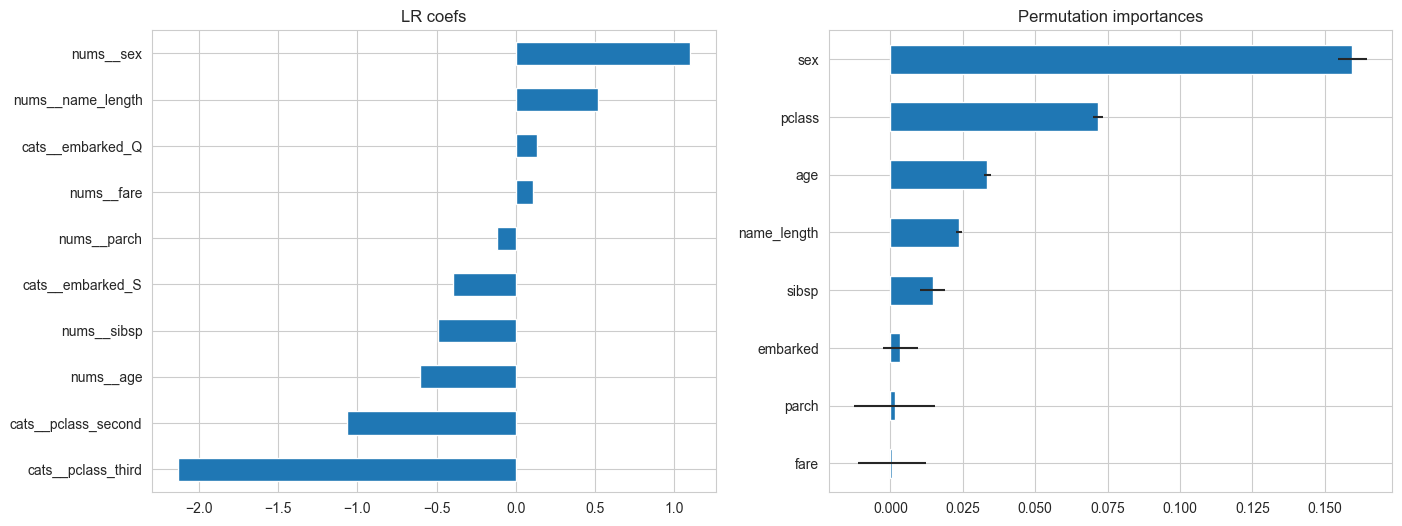

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

pd.Series(lr.named_steps['clf'].coef_.reshape(-1), index=lr.named_steps['transformer'].get_feature_names_out()).sort_values().plot.barh(ax=ax1);
ax1.set_title('LR coefs');

r = permutation_importance(lr, x_train, y_train, scoring='roc_auc', n_repeats=30, random_state=123)
pd.Series(r.importances_mean, index=x_train.columns).sort_values().plot.barh(xerr=r.importances_std, ax=ax2);
ax2.set_title('Permutation importances');

### Добавление полиномиальных признаков

In [32]:
num_ct_poly = Pipeline(steps=[('imputer', IterativeImputer(random_state=123)),
                              ('scaler', StandardScaler()),
                              ('poly', PolynomialFeatures())])

cat_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                         ('ohe', OneHotEncoder(drop='first'))])

transformer_poly = ColumnTransformer(transformers=[('nums', num_ct_poly, selector(dtype_exclude="object")),
                                                   ('cats', cat_ct, selector(dtype_include="object"))],
                                                    remainder='passthrough')

clf_lr = LogisticRegression()
# lr_pipe = Pipeline(steps=[('transformer', transformer_poly), ('clf', clf_lr)])
#
# lr_pipe.fit(x, y)

In [33]:
rfe = RFE(clf_lr)

In [34]:
# создание словаря с признаками после всех преобразований можно было использовать rfe.support_
poly_features = pd.DataFrame({f'x{i}': transformer_poly.fit_transform(x_train)[: , i] for i in range(1, transformer_poly.fit_transform(x_train).shape[1])})
poly_features.sample()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31
335,1.355232,0.407639,-0.460103,-0.474312,-0.218246,-0.080729,1.836653,0.552446,-0.623546,-0.642803,...,0.224972,0.103517,0.038291,0.047631,0.017619,0.006517,1.0,0.0,0.0,1.0


In [35]:
rfe.fit(poly_features, y_train)

C:\work_and_fun\partisans\PP\mistakes-and-regrets\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RFE(estimator=LogisticRegression())

In [36]:
rfe.ranking_

array([ 1,  1, 14, 11,  1,  1,  1,  1, 10,  2,  1,  1,  7,  1,  1,  1,  9,
        1, 15, 17,  8,  5, 12,  3, 13, 16,  6,  1,  1,  4,  1])

In [37]:
rfe.estimator_.coef_

array([[ 0.91629682, -0.35695898,  0.21786848,  0.52987345,  0.56544174,
         0.37042107,  0.47137532, -0.27034299,  0.18905224, -0.49893444,
         0.58547265, -0.27852124, -0.82206213, -1.63396132, -0.49676722]])

In [38]:
rfe_imp_features = rfe.get_feature_names_out()
rfe_imp_features.shape

(15,)

In [39]:
cross_val_score(clf_lr, poly_features[rfe_imp_features], y_train, cv=3, scoring='roc_auc').mean()

0.868694147549881

### Встраивание RFE в Gridsearch

In [40]:
# класс, который возвращает коэффициенты логистической регрессии
# https://stackoverflow.com/questions/36683230/grid-search-with-recursive-feature-elimination-in-scikit-learn-pipeline-returns

class MyPipe(Pipeline):

    def fit(self, X, y=None, **fit_params):
        """Calls last elements .coef_ method.
        Based on the sourcecode for decision_function(X).
        Link: https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/pipeline.py
        ----------
        """
        super(MyPipe, self).fit(X, y, **fit_params)
        self.coef_ = self.steps[-1][-1].coef_
        return self

In [41]:
num_ct_poly = Pipeline(steps=[('imputer', IterativeImputer(random_state=123)),
                              ('scaler', StandardScaler()),
                              ('poly', PolynomialFeatures())])

cat_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                         ('ohe', OneHotEncoder(drop='first'))])

transformer_poly = ColumnTransformer(transformers=[('nums', num_ct_poly, selector(dtype_exclude="object")),
                                                   ('cats', cat_ct, selector(dtype_include="object"))],
                                                    remainder='passthrough')

x_poly = transformer_poly.fit_transform(x_train)

params = [{'rfe__estimator__penalty': [None, 'l2'],
           'rfe__estimator__C': [0.1, 1, 10, 100],
           'rfe__n_features_to_select': range(5, 20)
          }]

clf_lr = LogisticRegression()
rfe = RFE(estimator=clf_lr, verbose=99)

lr_pipe_poly = Pipeline(steps=[('transformer', transformer_poly), ('rfe', rfe)])

lr_gs_poly=GridSearchCV(estimator=lr_pipe_poly,
                        param_grid=params,
                        scoring='roc_auc',
                        refit=True,
                        cv=3,
                        n_jobs=-1,
                        verbose=10)

lr_gs_poly.fit(x_train, y_train)

Fitting 3 folds for each of 120 candidates, totalling 360 fits
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('nums',
                                                                         Pipeline(steps=[('imputer',
                                                                                          IterativeImputer(random_state=123)),
                                                                                         ('scaler',
                                                                                          StandardScaler()),
                                                                                         ('poly',
                                                                                          PolynomialFeatures())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000212A5CD4790>),
                                                                        ('cats',
                                                                         Pipeline(s...
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000212A5CD4DF0>)])),
                                       ('rfe',
                                        RFE(estimator=LogisticRegression(),
                                            verbose=99))]),
             n_jobs=-1,
             param_grid=[{'rfe__estimator__C': [0.1, 1, 10, 100],
                          'rfe__estimator__penalty': [None, 'l2'],
                          'rfe__n_features_to_select': range(5, 20)}],
             scoring='roc_auc', verbose=10)

In [42]:
pd.DataFrame(lr_gs_poly.cv_results_).sort_values('rank_test_score').head(33)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfe__estimator__C,param_rfe__estimator__penalty,param_rfe__n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
24,0.411332,0.040713,0.022999,7.117626e-03,0.1,l2,14,"{'rfe__estimator__C': 0.1, 'rfe__estimator__pe...",0.876863,0.811019,0.890555,0.859479,0.034719,1
85,0.488000,0.008288,0.014000,1.655632e-06,10,l2,15,"{'rfe__estimator__C': 10, 'rfe__estimator__pen...",0.875454,0.821664,0.880960,0.859359,0.026749,2
115,0.404666,0.064999,0.014000,8.165352e-04,100,l2,15,"{'rfe__estimator__C': 100, 'rfe__estimator__pe...",0.875232,0.821064,0.881409,0.859235,0.027108,3
11,0.382005,0.039640,0.015661,1.692490e-03,0.1,None,16,"{'rfe__estimator__C': 0.1, 'rfe__estimator__pe...",0.875158,0.821139,0.881334,0.859210,0.027038,4
41,0.356333,0.010077,0.014000,9.798072e-07,1,None,16,"{'rfe__estimator__C': 1, 'rfe__estimator__pena...",0.875158,0.821139,0.881334,0.859210,0.027038,4
101,0.381666,0.036809,0.015000,2.159796e-03,100,None,16,"{'rfe__estimator__C': 100, 'rfe__estimator__pe...",0.875158,0.821139,0.881334,0.859210,0.027038,4
71,0.389668,0.046690,0.015333,1.887956e-03,10,None,16,"{'rfe__estimator__C': 10, 'rfe__estimator__pen...",0.875158,0.821139,0.881334,0.859210,0.027038,4
26,0.250001,0.013736,0.015332,4.698531e-04,0.1,l2,16,"{'rfe__estimator__C': 0.1, 'rfe__estimator__pe...",0.875380,0.816567,0.883208,0.858385,0.029742,8
25,0.309666,0.050341,0.015003,4.913197e-06,0.1,l2,15,"{'rfe__estimator__C': 0.1, 'rfe__estimator__pe...",0.874713,0.814543,0.885307,0.858188,0.031163,9
28,0.252999,0.026127,0.014333,4.717090e-04,0.1,l2,18,"{'rfe__estimator__C': 0.1, 'rfe__estimator__pe...",0.877308,0.812369,0.884858,0.858178,0.032538,10


НИЧЕГО НЕ ПОЛУЧИЛОСЬ

### Метод опорных векторов

#### SVC

In [43]:
%%time
num_ct = Pipeline(steps=[('imputer', IterativeImputer(random_state=123)),
                         ('scaler', StandardScaler())])

cat_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                         ('ohe', OneHotEncoder(drop='first'))])

transformer = ColumnTransformer(transformers=[('nums', num_ct, selector(dtype_exclude="object")),
                                              ('cats', cat_ct, selector(dtype_include="object"))],
                                                    remainder='passthrough')

# Параметр probability нужен, чтобы вернулись predict_proba. Это нужно для построения roc-auc и soft-voting
svm_pipe = Pipeline(steps=[('transformer', transformer), ('estimator', SVC(random_state=123, probability=True))])

params = {'transformer__nums__scaler': [StandardScaler(), MinMaxScaler()],
          'estimator__C': range(1, 20),
          'estimator__gamma': [i/10000 for i in range(10)]}

gs_svm = GridSearchCV(svm_pipe, param_grid=params, scoring='roc_auc', cv=3, n_jobs=-1, refit=True)

gs_svm.fit(x_train, y_train)
# {'estimator__C': 9, 'estimator__gamma': 0.009
svm_best = gs_svm.best_estimator_


CPU times: total: 3.84 s
Wall time: 17.8 s


In [44]:
display(pd.DataFrame(gs_svm.cv_results_).sort_values('rank_test_score'))
print(f'параметры: {pd.DataFrame(gs_svm.cv_results_).sort_values("rank_test_score").head(1)["params"].values[0]}',
      f'\nroc-auc: {pd.DataFrame(gs_svm.cv_results_).sort_values("rank_test_score").head(1)["mean_test_score"].values[0]:.4f}')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__C,param_estimator__gamma,param_transformer__nums__scaler,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
319,0.135332,0.004028,0.028334,0.000471,16,0.0009,MinMaxScaler(),"{'estimator__C': 16, 'estimator__gamma': 0.000...",0.860771,0.799925,0.885157,0.848618,0.035841,1
379,0.123331,0.003771,0.016000,0.002450,19,0.0009,MinMaxScaler(),"{'estimator__C': 19, 'estimator__gamma': 0.000...",0.860771,0.798126,0.886882,0.848593,0.037244,2
299,0.140000,0.004082,0.030000,0.000817,15,0.0009,MinMaxScaler(),"{'estimator__C': 15, 'estimator__gamma': 0.000...",0.859733,0.800750,0.885232,0.848572,0.035381,3
357,0.134662,0.002500,0.029001,0.000817,18,0.0008,MinMaxScaler(),"{'estimator__C': 18, 'estimator__gamma': 0.000...",0.860623,0.799775,0.885157,0.848518,0.035893,4
375,0.149332,0.003771,0.030668,0.008178,19,0.0007,MinMaxScaler(),"{'estimator__C': 19, 'estimator__gamma': 0.000...",0.859511,0.800750,0.885232,0.848498,0.035358,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,0.132332,0.006343,0.035668,0.007319,14,0.0,MinMaxScaler(),"{'estimator__C': 14, 'estimator__gamma': 0.0, ...",0.500000,0.500000,0.500000,0.500000,0.000000,343
260,0.126666,0.002493,0.031667,0.000472,14,0.0,StandardScaler(),"{'estimator__C': 14, 'estimator__gamma': 0.0, ...",0.500000,0.500000,0.500000,0.500000,0.000000,343
80,0.124000,0.002450,0.039001,0.012028,5,0.0,StandardScaler(),"{'estimator__C': 5, 'estimator__gamma': 0.0, '...",0.500000,0.500000,0.500000,0.500000,0.000000,343
300,0.125001,0.002829,0.031332,0.001886,16,0.0,StandardScaler(),"{'estimator__C': 16, 'estimator__gamma': 0.0, ...",0.500000,0.500000,0.500000,0.500000,0.000000,343


параметры: {'estimator__C': 16, 'estimator__gamma': 0.0009, 'transformer__nums__scaler': MinMaxScaler()} 
roc-auc: 0.8486


#### LinearSVC

In [45]:
%%time
num_ct = Pipeline(steps=[('imputer', IterativeImputer(random_state=123)),
                         ('scaler', StandardScaler())])

cat_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                         ('ohe', OneHotEncoder(drop='first'))])

transformer = ColumnTransformer(transformers=[('nums', num_ct, selector(dtype_exclude="object")),
                                              ('cats', cat_ct, selector(dtype_include="object"))],
                                                    remainder='passthrough')


svm_pipe = Pipeline(steps=[('transformer', transformer), ('estimator', LinearSVC(max_iter=100000, random_state=123))])

params = {'transformer__nums__scaler': [StandardScaler(), MinMaxScaler()],
          'estimator__C': [2*i/100 for i in range(1, 100)]}

gs_lsvm = GridSearchCV(svm_pipe, param_grid=params, scoring='roc_auc', cv=3, n_jobs=-1, refit=True, error_score='raise')
gs_lsvm.fit(x_train, y_train);
lsvm_best = gs_lsvm.best_estimator_

CPU times: total: 1.81 s
Wall time: 5.22 s


In [46]:
display(pd.DataFrame(gs_lsvm.cv_results_).sort_values('rank_test_score'))
print(f'параметры: {pd.DataFrame(gs_lsvm.cv_results_).sort_values("rank_test_score").head(1)["params"].values[0]}',
      f'\nroc-auc: {pd.DataFrame(gs_lsvm.cv_results_).sort_values("rank_test_score").head(1)["mean_test_score"].values[0]:.4f}')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__C,param_transformer__nums__scaler,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
189,0.060999,0.001414,0.013001,0.001414,1.9,MinMaxScaler(),"{'estimator__C': 1.9, 'transformer__nums__scal...",0.871376,0.810495,0.884258,0.855376,0.032169,1
191,0.064664,0.005436,0.013668,0.001701,1.92,MinMaxScaler(),"{'estimator__C': 1.92, 'transformer__nums__sca...",0.871301,0.810495,0.884258,0.855351,0.032156,2
187,0.066340,0.007132,0.012662,0.000467,1.88,MinMaxScaler(),"{'estimator__C': 1.88, 'transformer__nums__sca...",0.871301,0.810495,0.884258,0.855351,0.032156,2
183,0.070334,0.008993,0.018332,0.002495,1.84,MinMaxScaler(),"{'estimator__C': 1.84, 'transformer__nums__sca...",0.871301,0.810420,0.884258,0.855326,0.032191,4
185,0.061333,0.001248,0.017001,0.003266,1.86,MinMaxScaler(),"{'estimator__C': 1.86, 'transformer__nums__sca...",0.871301,0.810420,0.884258,0.855326,0.032191,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,0.053672,0.001251,0.013662,0.000468,0.1,MinMaxScaler(),"{'estimator__C': 0.1, 'transformer__nums__scal...",0.868113,0.805172,0.880435,0.851240,0.032961,194
7,0.065328,0.003395,0.012667,0.000943,0.08,MinMaxScaler(),"{'estimator__C': 0.08, 'transformer__nums__sca...",0.866926,0.804498,0.880735,0.850720,0.033166,195
5,0.055333,0.002345,0.014996,0.002832,0.06,MinMaxScaler(),"{'estimator__C': 0.06, 'transformer__nums__sca...",0.865369,0.804573,0.880660,0.850200,0.032862,196
3,0.059666,0.004644,0.012666,0.000944,0.04,MinMaxScaler(),"{'estimator__C': 0.04, 'transformer__nums__sca...",0.863515,0.804198,0.879835,0.849183,0.032499,197


параметры: {'estimator__C': 1.9, 'transformer__nums__scaler': MinMaxScaler()} 
roc-auc: 0.8554


## Наивный Байес

In [47]:
%%time
num_ct = Pipeline(steps=[('imputer', IterativeImputer(random_state=123)),
                         ('scaler', MinMaxScaler())])

cat_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                         ('ohe', OneHotEncoder(drop='first'))])

transformer_poly = ColumnTransformer(transformers=[('nums', num_ct, selector(dtype_exclude="object")),
                                                   ('cats', cat_ct, selector(dtype_include="object"))],
                                                    remainder='passthrough')

bayes_pipe = Pipeline(steps=[('transformer', transformer_poly), ('estimator', BernoulliNB())])

params = [{'estimator': [BernoulliNB(), CategoricalNB(), ComplementNB()],
           'estimator__alpha': [0.1, 1, 10]},

          {'estimator': [GaussianNB()]}
         ]

gs_bayes = GridSearchCV(bayes_pipe, param_grid=params, scoring='roc_auc', cv=3, n_jobs=-1)

gs_bayes.fit(x_train, y_train);

CPU times: total: 125 ms
Wall time: 292 ms


In [48]:
display(pd.DataFrame(gs_bayes.cv_results_).sort_values('rank_test_score'))
print(f'параметры: {pd.DataFrame(gs_bayes.cv_results_).sort_values("rank_test_score").head(1)["params"].values[0]}',
      f'\nroc-auc: {pd.DataFrame(gs_bayes.cv_results_).sort_values("rank_test_score").head(1)["mean_test_score"].values[0]:.4f}')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_estimator__alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
7,0.064665,0.006181,0.013665,0.001248,ComplementNB(alpha=1),1,"{'estimator': ComplementNB(alpha=1), 'estimato...",0.840971,0.787481,0.867766,0.832073,0.033375,1
6,0.066003,0.013733,0.013665,0.000472,ComplementNB(alpha=1),0.1,"{'estimator': ComplementNB(alpha=1), 'estimato...",0.841194,0.787931,0.865892,0.831672,0.032532,2
8,0.052664,0.002624,0.011667,0.001247,ComplementNB(alpha=1),10,"{'estimator': ComplementNB(alpha=1), 'estimato...",0.838895,0.784858,0.868216,0.830656,0.034526,3
9,0.048331,0.003398,0.010332,0.001245,GaussianNB(),NaN,{'estimator': GaussianNB()},0.826585,0.796777,0.860720,0.828027,0.026125,4
0,0.053998,0.000814,0.016000,0.000817,BernoulliNB(),0.1,"{'estimator': BernoulliNB(), 'estimator__alpha...",0.828105,0.776537,0.854648,0.819763,0.032430,5
1,0.057336,0.002629,0.015330,0.001244,BernoulliNB(),1,"{'estimator': BernoulliNB(), 'estimator__alpha...",0.827364,0.773838,0.856897,0.819366,0.034377,6
4,0.070333,0.005436,0.021334,0.005249,CategoricalNB(),1,"{'estimator': CategoricalNB(), 'estimator__alp...",0.824064,0.778636,0.854835,0.819178,0.031300,7
3,0.066332,0.003298,0.027666,0.020039,CategoricalNB(),0.1,"{'estimator': CategoricalNB(), 'estimator__alp...",0.825102,0.780735,0.850937,0.818925,0.028991,8
5,0.056667,0.002494,0.014334,0.001884,CategoricalNB(),10,"{'estimator': CategoricalNB(), 'estimator__alp...",0.823322,0.777211,0.854835,0.818456,0.031876,9
2,0.055666,0.002053,0.015667,0.001700,BernoulliNB(),10,"{'estimator': BernoulliNB(), 'estimator__alpha...",0.824842,0.771514,0.856447,0.817601,0.035050,10


параметры: {'estimator': ComplementNB(alpha=1), 'estimator__alpha': 1} 
roc-auc: 0.8321


## Деревянные модели

### Дерево решений

In [49]:
%%time
num_ct = Pipeline(steps=[('imputer', IterativeImputer(random_state=123))])

cat_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                         ('encoder', OneHotEncoder(drop='first'))])

transformer = ColumnTransformer(transformers=[('nums', num_ct, selector(dtype_exclude="object")),
                                                   ('cats', cat_ct, selector(dtype_include="object"))],
                                                    remainder='passthrough')

tree_pipe = Pipeline(steps=[('transformer', transformer), ('clf', DecisionTreeClassifier(random_state=123))])

tree_params = {'transformer__cats__encoder': [OneHotEncoder(drop='first'), LabelEncoder()],
               'clf__max_depth': [2, 3, 4, 5, 7, 9],
               'clf__min_samples_split': [2, 3, 4, 5, 6, 8, 9, 10, 11],
               'clf__min_samples_leaf': [3, 5, 8, 9, 10, 11, 12, 14, 16]}

tree_gs = GridSearchCV(tree_pipe, param_grid=tree_params, scoring='roc_auc', cv=3, n_jobs=-1)
tree_gs.fit(x_train, y_train);
tree_best = tree_gs.best_estimator_

CPU times: total: 7.55 s
Wall time: 18 s


C:\work_and_fun\partisans\PP\mistakes-and-regrets\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
1458 fits failed out of a total of 2916.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1458 fits failed with the following error:
Traceback (most recent call last):
  File "C:\work_and_fun\partisans\PP\mistakes-and-regrets\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\work_and_fun\partisans\PP\mistakes-and-regrets\lib\site-packages\sklearn\pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\work_and_fun\partisans\PP\mistakes-and-regrets\lib\site-packages\sklearn\pipeline.p

In [50]:
display(pd.DataFrame(tree_gs.cv_results_).sort_values('rank_test_score'))
print(f'параметры: {pd.DataFrame(tree_gs.cv_results_).sort_values("rank_test_score").head(1)["params"].values[0]}',
      f'\nroc-auc: {pd.DataFrame(tree_gs.cv_results_).sort_values("rank_test_score").head(1)["mean_test_score"].values[0]:.4f}')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__max_depth,param_clf__min_samples_leaf,param_clf__min_samples_split,param_transformer__cats__encoder,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
494,0.062667,0.009427,0.013334,0.000472,5,3,6,OneHotEncoder(drop='first'),"{'clf__max_depth': 5, 'clf__min_samples_leaf':...",0.881683,0.799438,0.837256,0.839459,0.033613,1
492,0.068667,0.008956,0.016000,0.002828,5,3,5,OneHotEncoder(drop='first'),"{'clf__max_depth': 5, 'clf__min_samples_leaf':...",0.881683,0.799438,0.837256,0.839459,0.033613,1
490,0.057000,0.002450,0.016000,0.002159,5,3,4,OneHotEncoder(drop='first'),"{'clf__max_depth': 5, 'clf__min_samples_leaf':...",0.881683,0.799438,0.837256,0.839459,0.033613,1
488,0.052333,0.000471,0.012333,0.000471,5,3,3,OneHotEncoder(drop='first'),"{'clf__max_depth': 5, 'clf__min_samples_leaf':...",0.881683,0.799438,0.837256,0.839459,0.033613,1
486,0.056000,0.002160,0.016333,0.002054,5,3,2,OneHotEncoder(drop='first'),"{'clf__max_depth': 5, 'clf__min_samples_leaf':...",0.881683,0.799438,0.837256,0.839459,0.033613,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,0.049666,0.003091,0.000000,0.000000,4,12,3,LabelEncoder(),"{'clf__max_depth': 4, 'clf__min_samples_leaf':...",NaN,NaN,NaN,NaN,NaN,487
437,0.055000,0.007071,0.000000,0.000000,4,12,4,LabelEncoder(),"{'clf__max_depth': 4, 'clf__min_samples_leaf':...",NaN,NaN,NaN,NaN,NaN,487
439,0.049000,0.001633,0.000000,0.000000,4,12,5,LabelEncoder(),"{'clf__max_depth': 4, 'clf__min_samples_leaf':...",NaN,NaN,NaN,NaN,NaN,487
403,0.050333,0.001249,0.000000,0.000000,4,10,5,LabelEncoder(),"{'clf__max_depth': 4, 'clf__min_samples_leaf':...",NaN,NaN,NaN,NaN,NaN,487


параметры: {'clf__max_depth': 5, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 6, 'transformer__cats__encoder': OneHotEncoder(drop='first')} 
roc-auc: 0.8395


### Случайный лес

In [51]:
%%time
num_ct = Pipeline(steps=[('imputer', IterativeImputer(random_state=123))])

cat_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                         ('encoder', OneHotEncoder(drop='first'))])

transformer = ColumnTransformer(transformers=[('nums', num_ct, selector(dtype_exclude="object")),
                                              ('cats', cat_ct, selector(dtype_include="object"))],
                                                remainder='passthrough')

rf_pipe = Pipeline(steps=[('transformer', transformer), ('clf', RandomForestClassifier(random_state=123))])

rf_params = {'clf__n_estimators': [10, 15, 20, 25, 30],
             'clf__max_depth': [5, 6, 7, 8, 9],
             'clf__min_samples_split': [2, 3, 4, 5, 6],
             'clf__min_samples_leaf': [2, 3, 4, 5, 6, 7, 8]}

rf_gs = GridSearchCV(rf_pipe, param_grid=rf_params, scoring='roc_auc', cv=3, n_jobs=-1, refit=True)
rf_gs.fit(x_train, y_train);
rf_best = rf_gs.best_estimator_

CPU times: total: 8.67 s
Wall time: 30.8 s


In [52]:
display(pd.DataFrame(rf_gs.cv_results_).sort_values('rank_test_score'))
print(f'параметры: {pd.DataFrame(rf_gs.cv_results_).sort_values("rank_test_score").head(1)["params"].values[0]}',
      f'\nroc-auc: {pd.DataFrame(rf_gs.cv_results_).sort_values("rank_test_score").head(1)["mean_test_score"].values[0]:.4f}')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__max_depth,param_clf__min_samples_leaf,param_clf__min_samples_split,param_clf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
461,0.098644,0.000910,0.016309,0.000438,7,6,4,15,"{'clf__max_depth': 7, 'clf__min_samples_leaf':...",0.875603,0.828223,0.896252,0.866693,0.028478,1
456,0.100334,0.009105,0.018333,0.002624,7,6,3,15,"{'clf__max_depth': 7, 'clf__min_samples_leaf':...",0.875603,0.828223,0.896252,0.866693,0.028478,1
471,0.105667,0.006182,0.017000,0.000817,7,6,6,15,"{'clf__max_depth': 7, 'clf__min_samples_leaf':...",0.875603,0.828223,0.896252,0.866693,0.028478,1
451,0.110667,0.012499,0.017000,0.000816,7,6,2,15,"{'clf__max_depth': 7, 'clf__min_samples_leaf':...",0.875603,0.828223,0.896252,0.866693,0.028478,1
466,0.112507,0.010413,0.017000,0.000816,7,6,5,15,"{'clf__max_depth': 7, 'clf__min_samples_leaf':...",0.875603,0.828223,0.896252,0.866693,0.028478,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,0.134999,0.008043,0.018668,0.000942,7,8,3,25,"{'clf__max_depth': 7, 'clf__min_samples_leaf':...",0.853541,0.816004,0.871889,0.847145,0.023259,868
503,0.128863,0.005177,0.018334,0.000471,7,8,2,25,"{'clf__max_depth': 7, 'clf__min_samples_leaf':...",0.853541,0.816004,0.871889,0.847145,0.023259,868
700,0.091333,0.011086,0.016000,0.000816,9,2,2,10,"{'clf__max_depth': 9, 'clf__min_samples_leaf':...",0.861550,0.815630,0.862181,0.846454,0.021797,873
705,0.094333,0.017461,0.015666,0.000943,9,2,3,10,"{'clf__max_depth': 9, 'clf__min_samples_leaf':...",0.861550,0.815630,0.862181,0.846454,0.021797,873


параметры: {'clf__max_depth': 7, 'clf__min_samples_leaf': 6, 'clf__min_samples_split': 4, 'clf__n_estimators': 15} 
roc-auc: 0.8667


### ExtraTreesClassifier

In [53]:
%%time
num_ct = Pipeline(steps=[('imputer', IterativeImputer(random_state=123))])

cat_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                         ('encoder', OneHotEncoder(drop='first'))])

transformer = ColumnTransformer(transformers=[('nums', num_ct, selector(dtype_exclude="object")),
                                              ('cats', cat_ct, selector(dtype_include="object"))],
                                                remainder='passthrough')

et_pipe = Pipeline(steps=[('transformer', transformer), ('clf', ExtraTreesClassifier(random_state=123))])

et_params = {'clf__n_estimators': [10, 15, 20, 25, 30],
             'clf__max_depth': [5, 6, 7, 8, 9],
             'clf__min_samples_split': [2, 3, 4, 5, 6],
             'clf__min_samples_leaf': [2, 3, 4, 5, 6, 7, 8]}

et_gs = GridSearchCV(et_pipe, param_grid=et_params, scoring='roc_auc', cv=3, n_jobs=-1, refit=True)
et_gs.fit(x_train, y_train);
et_best = et_gs.best_estimator_

CPU times: total: 9.14 s
Wall time: 27.2 s


In [54]:
display(pd.DataFrame(et_gs.cv_results_).sort_values('rank_test_score'))
print(f'параметры: {pd.DataFrame(et_gs.cv_results_).sort_values("rank_test_score").head(1)["params"].values[0]}',
      f'\nroc-auc: {pd.DataFrame(et_gs.cv_results_).sort_values("rank_test_score").head(1)["mean_test_score"].values[0]:.4f}')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__max_depth,param_clf__min_samples_leaf,param_clf__min_samples_split,param_clf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
188,0.110000,0.000816,0.018334,4.714828e-04,6,2,4,25,"{'clf__max_depth': 6, 'clf__min_samples_leaf':...",0.871116,0.817091,0.904123,0.864110,0.035874,1
178,0.111333,0.001886,0.019333,4.712580e-04,6,2,2,25,"{'clf__max_depth': 6, 'clf__min_samples_leaf':...",0.871116,0.817091,0.904123,0.864110,0.035874,1
183,0.106666,0.001699,0.018667,4.716514e-04,6,2,3,25,"{'clf__max_depth': 6, 'clf__min_samples_leaf':...",0.871116,0.817091,0.904123,0.864110,0.035874,1
179,0.129333,0.006600,0.020000,8.920806e-07,6,2,2,30,"{'clf__max_depth': 6, 'clf__min_samples_leaf':...",0.870152,0.817354,0.903861,0.863789,0.035602,4
184,0.120000,0.003559,0.019667,4.714266e-04,6,2,3,30,"{'clf__max_depth': 6, 'clf__min_samples_leaf':...",0.870152,0.817354,0.903861,0.863789,0.035602,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.082665,0.013670,0.016001,1.083865e-06,5,7,6,10,"{'clf__max_depth': 5, 'clf__min_samples_leaf':...",0.853615,0.808621,0.855735,0.839323,0.021727,871
140,0.076999,0.006376,0.016000,2.247832e-07,5,7,5,10,"{'clf__max_depth': 5, 'clf__min_samples_leaf':...",0.853615,0.808621,0.855735,0.839323,0.021727,871
130,0.081665,0.011614,0.016334,1.885819e-03,5,7,3,10,"{'clf__max_depth': 5, 'clf__min_samples_leaf':...",0.853615,0.808621,0.855735,0.839323,0.021727,871
125,0.079667,0.008014,0.015333,4.712019e-04,5,7,2,10,"{'clf__max_depth': 5, 'clf__min_samples_leaf':...",0.853615,0.808621,0.855735,0.839323,0.021727,871


параметры: {'clf__max_depth': 6, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 4, 'clf__n_estimators': 25} 
roc-auc: 0.8641


### RandomTreesEmbedding

In [55]:
%%time
num_ct = Pipeline(steps=[('imputer', IterativeImputer(random_state=123))])

cat_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                         ('encoder', OneHotEncoder(drop='first'))])

transformer = ColumnTransformer(transformers=[('nums', num_ct, selector(dtype_exclude="object")),
                                              ('cats', cat_ct, selector(dtype_include="object"))],
                                                remainder='passthrough')

rte_pipe = Pipeline(steps=[('transformer', transformer), ('clf', RandomTreesEmbedding(random_state=123))])

rte_params = {'clf__n_estimators': [10, 15, 20, 25, 30],
             'clf__max_depth': [5, 6, 7, 8, 9],
             'clf__min_samples_split': [2, 3, 4, 5, 6],
             'clf__min_samples_leaf': [2, 3, 4, 5, 6, 7, 8]}

rte_gs = GridSearchCV(rte_pipe, param_grid=rte_params, scoring='roc_auc', cv=3, n_jobs=-1)
rte_gs.fit(x_train, y_train);

CPU times: total: 9.06 s
Wall time: 24.1 s


C:\work_and_fun\partisans\PP\mistakes-and-regrets\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan 

In [56]:
display(pd.DataFrame(rte_gs.cv_results_).sort_values('rank_test_score'))
print(f'параметры: {pd.DataFrame(rte_gs.cv_results_).sort_values("rank_test_score").head(1)["params"].values[0]}',
      f'\nroc-auc: {pd.DataFrame(rte_gs.cv_results_).sort_values("rank_test_score").head(1)["mean_test_score"].values[0]:.4f}')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__max_depth,param_clf__min_samples_leaf,param_clf__min_samples_split,param_clf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.070004,0.008602,0.002333,4.703589e-04,5,2,2,10,"{'clf__max_depth': 5, 'clf__min_samples_leaf':...",NaN,NaN,NaN,NaN,NaN,1
576,0.096667,0.005557,0.001334,4.709770e-04,8,4,2,15,"{'clf__max_depth': 8, 'clf__min_samples_leaf':...",NaN,NaN,NaN,NaN,NaN,1
577,0.110666,0.007760,0.001334,4.713705e-04,8,4,2,20,"{'clf__max_depth': 8, 'clf__min_samples_leaf':...",NaN,NaN,NaN,NaN,NaN,1
578,0.110333,0.002494,0.001333,4.713714e-04,8,4,2,25,"{'clf__max_depth': 8, 'clf__min_samples_leaf':...",NaN,NaN,NaN,NaN,NaN,1
579,0.118333,0.001248,0.001334,4.708084e-04,8,4,2,30,"{'clf__max_depth': 8, 'clf__min_samples_leaf':...",NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,0.095001,0.002160,0.001000,0.000000e+00,6,6,6,15,"{'clf__max_depth': 6, 'clf__min_samples_leaf':...",NaN,NaN,NaN,NaN,NaN,1
297,0.098666,0.001700,0.001334,4.714831e-04,6,6,6,20,"{'clf__max_depth': 6, 'clf__min_samples_leaf':...",NaN,NaN,NaN,NaN,NaN,1
298,0.112001,0.002161,0.001999,1.184119e-06,6,6,6,25,"{'clf__max_depth': 6, 'clf__min_samples_leaf':...",NaN,NaN,NaN,NaN,NaN,1
287,0.102000,0.001413,0.001333,4.713142e-04,6,6,4,20,"{'clf__max_depth': 6, 'clf__min_samples_leaf':...",NaN,NaN,NaN,NaN,NaN,1


параметры: {'clf__max_depth': 5, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 10} 
roc-auc: nan


## Ансамбли

### BaggingClassifier

BaggingClassifier почему-то не воспринимает трансформации по типам колонок внутри пайплайна, поэтому перепишем трансформер и пересоберем пайплайн, указав трансформируемые признаки индексами

In [57]:
num_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                         ('scaler', StandardScaler())])

cat_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                         ('ohe', OneHotEncoder(drop='first'))])

transformer = ColumnTransformer(transformers=[('nums', num_ct, (1, 2, 3, 4, 5, 7)),
                                              ('cats', cat_ct, [0, 6])],
                                remainder='passthrough')

lr_pipe = Pipeline(steps=[('transformer', transformer), ('clf', LogisticRegression(random_state=123))])

params = [{'transformer__nums__imputer': [SimpleImputer()],
           'transformer__nums__imputer__strategy': ['mean', 'median'],
           'clf__penalty': ['none', 'l2'],
           'clf__C': [0.1, 1, 10, 100]
          },
          { 'transformer__nums__imputer': [IterativeImputer(random_state=123)],
           'clf__penalty': ['none', 'l2'],
           'clf__C': [0.1, 1, 10, 100]
          }]

lr_gs    = GridSearchCV(estimator=lr_pipe,
                        param_grid=params,
                        scoring='roc_auc',
                        refit=True,
                        cv=3,
                        n_jobs=-1,
                        verbose=10)
lr_gs.fit(x_train, y_train)
lr_best = lr_gs.best_estimator_;

Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [58]:
bc = BaggingClassifier(estimator=lr_best, n_estimators=10, random_state=123)
cross_val_score(bc, x_train, y_train, scoring='roc_auc', cv=5, n_jobs=-1).mean().round(4)

0.8526

ну хз

### StackingClassifier

In [59]:
sc = StackingClassifier(estimators=[('rf', rf_best), ('et', et_best)],
                        final_estimator=RandomForestClassifier(n_estimators=15, max_depth=7),
                        cv=3,
                        n_jobs=-1)
cross_val_score(sc, x_train, y_train, scoring='roc_auc', cv=5, n_jobs=-1).mean().round(4)

0.8153

### VotingClassifier

In [60]:
vc = VotingClassifier(estimators=[('lr', lr_best),
                                  ('tree', tree_best),
                                  ('rf', rf_best),
                                  ('et', et_best)],
                      voting='soft', n_jobs=-1)
print(cross_val_score(vc, x_train, y_train, scoring='roc_auc', cv=3, n_jobs=-1).mean().round(4))

0.8703


## Градиентный бустинг

### XGBoost

In [65]:
%%time
xgbst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic', enable_categorical=True)
xgbst.fit(x_train, y_train)

ValueError: Experimental support for categorical data is not implemented for current tree method yet.

## Построение графиков roc-auc кривых

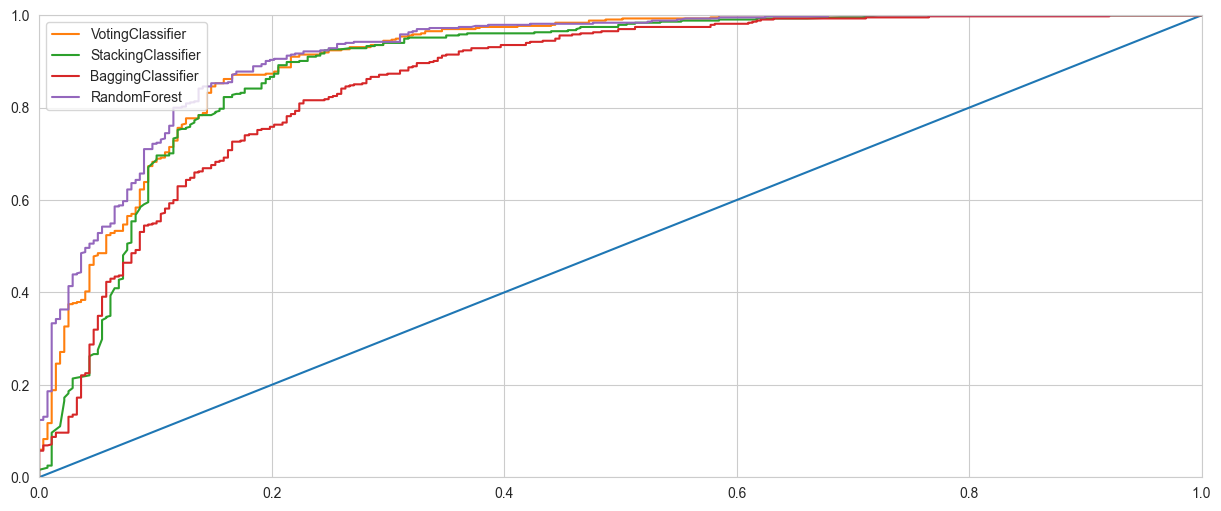

In [62]:
plt.figure(figsize=(15, 6));
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.plot([0, 1], [0, 1]);

for model, label in zip((vc, sc, bc, rf_best),
                        ('VotingClassifier', 'StackingClassifier', 'BaggingClassifier', 'RandomForest')):
    fpr, tpr, thresholds = roc_curve(y_train, model.fit(x_train, y_train).predict_proba(x_train)[:, 0])
    plt.plot(tpr, fpr, label=label);
    plt.legend(loc='lower right')
    plt.legend(loc='upper left')

In [63]:
roc_auc_score(y_train, vc.fit(x_train, y_train).predict(x_train))

0.8363708037677912

In [64]:
roc_auc_score(y_train, rf_best.fit(x_train, y_train).predict(x_train))

0.8322751981410017